
# 05 · PyTorch Neural Network Classification

> Tip: If you're on Colab, go to **Runtime → Change runtime type → GPU** for faster training.


In [ ]:
%%capture
# Minimal installs (Colab usually has these; torchmetrics may not)
!pip install torchmetrics==1.3.0


In [ ]:

# Core imports
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Data utils
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.model_selection import train_test_split

# Metrics
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy

# Reproducibility + device-agnostic
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'


## Helper Functions (Plotting)
We’ll use two small utilities:
- `plot_points(X, y)`: quick scatter.
- `plot_decision_boundary(model, X, y)`: visualize model regions.


In [ ]:

def plot_points(X, y, title=None):
    X_ = X.detach().cpu().numpy() if torch.is_tensor(X) else np.asarray(X)
    y_ = y.detach().cpu().numpy() if torch.is_tensor(y) else np.asarray(y)
    plt.figure(figsize=(5,5))
    plt.scatter(X_[:,0], X_[:,1], c=y_, s=12)
    if title: plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()


@torch.inference_mode()
def plot_decision_boundary(model, X, y, title=None, steps=300):
    model.eval()
    X_cpu = X.detach().cpu().numpy() if torch.is_tensor(X) else np.asarray(X)
    x_min, x_max = X_cpu[:, 0].min() - 0.5, X_cpu[:, 0].max() + 0.5
    y_min, y_max = X_cpu[:, 1].min() - 0.5, X_cpu[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, steps),
        np.linspace(y_min, y_max, steps)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32, device=device)
    logits = model(grid_t)

    # Handle binary vs multiclass
    if logits.shape[1] == 1:
        probs = torch.sigmoid(logits).squeeze(1)
        Z = (probs >= 0.5).long().detach().cpu().numpy()
    else:
        probs = torch.softmax(logits, dim=1)
        Z = torch.argmax(probs, dim=1).detach().cpu().numpy()

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, alpha=0.25)
    X_ = X.detach().cpu().numpy() if torch.is_tensor(X) else np.asarray(X)
    y_ = y.detach().cpu().numpy() if torch.is_tensor(y) else np.asarray(y)
    plt.scatter(X_[:, 0], X_[:, 1], c=y_, s=12, edgecolors="none")
    if title: plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()



## 0) Architecture of a Classification Network (Quick Reference)

**Binary classification**
- Input: `in_features = # of columns in X`
- Hidden(s): 1+ layers, **ReLU** commonly
- Output: `out_features = 1`
- Activation (for inference): **Sigmoid**
- Loss: **BCEWithLogitsLoss** (sigmoid built-in)

**Multi-class**
- Input: same rule
- Hidden(s): ReLU commonly
- Output: `out_features = #classes`
- Activation (for inference): **Softmax**
- Loss: **CrossEntropyLoss** (softmax built-in)



## 1) Make Binary Classification Data (Circles)
We’ll create a toy dataset of two concentric circles. Perfect to show why **non-linearity** matters.


Shapes: torch.Size([1000, 2]) torch.Size([1000])


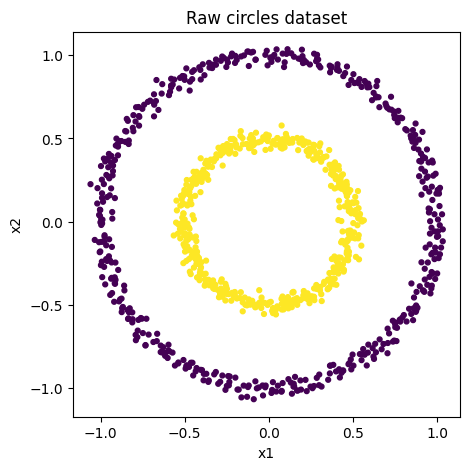

In [ ]:

# Create circles
X, y = make_circles(n_samples=1000, noise=0.03, factor=0.5, random_state=seed)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print("Shapes:", X.shape, y.shape)
plot_points(X, y, title="Raw circles dataset")


In [ ]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

X_train = X_train.to(device); X_test = X_test.to(device)
y_train = y_train.to(device); y_test = y_test.to(device)

len(X_train), len(X_test)


(800, 200)


## 2) Build a Simple Classifier (No Non-linearity yet)
Let’s start with a linear-only network to show its limits on circular data.


In [ ]:

class LinearCircleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1)  # 1 logit for binary
        )
    def forward(self, x):
        return self.net(x)

model_linear = LinearCircleNet().to(device)
model_linear


LinearCircleNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_linear.parameters(), lr=0.1)

metric = BinaryAccuracy().to(device)  # threshold=0.5 by default



## 3) Train (Short) and Evaluate
We’ll quickly confirm that a linear-only model struggles with circular patterns.


Epoch    1 | train_loss=0.7003 | test_loss=0.7050 | test_acc=42.50%
Epoch   20 | train_loss=0.6963 | test_loss=0.7003 | test_acc=47.00%
Epoch   40 | train_loss=0.6950 | test_loss=0.6983 | test_acc=46.00%
Epoch   60 | train_loss=0.6943 | test_loss=0.6971 | test_acc=46.50%
Epoch   80 | train_loss=0.6939 | test_loss=0.6962 | test_acc=47.00%
Epoch  100 | train_loss=0.6936 | test_loss=0.6956 | test_acc=46.50%
Epoch  120 | train_loss=0.6934 | test_loss=0.6951 | test_acc=47.50%


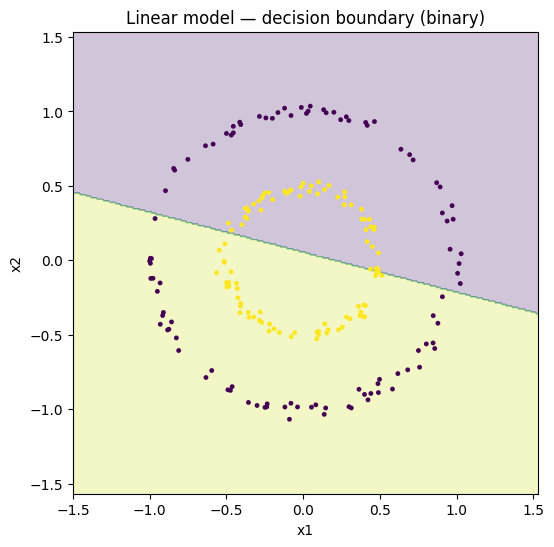

In [ ]:

def train_binary(model, epochs=100, report_every=20):
    for epoch in range(1, epochs+1):
        model.train()
        logits = model(X_train).squeeze(1)
        loss = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % report_every == 0 or epoch == 1:
            model.eval()
            with torch.inference_mode():
                test_logits = model(X_test).squeeze(1)
                test_loss = loss_fn(test_logits, y_test)
                preds = torch.sigmoid(test_logits) >= 0.5
                acc = metric(preds, y_test.int())
            print(f"Epoch {epoch:4d} | train_loss={loss.item():.4f} | test_loss={test_loss.item():.4f} | test_acc={acc.item()*100:.2f}%")

train_binary(model_linear, epochs=120, report_every=20)
plot_decision_boundary(model_linear, X_test, y_test, title="Linear model — decision boundary (binary)")



## 4) Add Non-Linearity (ReLU) and Train Longer
This time we interleave **ReLU** between layers so the model can draw **curves**, not just straight lines.


Epoch    1 | train_loss=0.6916 | test_loss=0.6864 | test_acc=49.00%
Epoch  100 | train_loss=0.0064 | test_loss=0.0057 | test_acc=100.00%
Epoch  200 | train_loss=0.0015 | test_loss=0.0013 | test_acc=100.00%
Epoch  300 | train_loss=0.0006 | test_loss=0.0006 | test_acc=100.00%
Epoch  400 | train_loss=0.0003 | test_loss=0.0003 | test_acc=100.00%
Epoch  500 | train_loss=0.0002 | test_loss=0.0002 | test_acc=100.00%
Epoch  600 | train_loss=0.0002 | test_loss=0.0001 | test_acc=100.00%
Epoch  700 | train_loss=0.0001 | test_loss=0.0001 | test_acc=100.00%
Epoch  800 | train_loss=0.0001 | test_loss=0.0001 | test_acc=100.00%


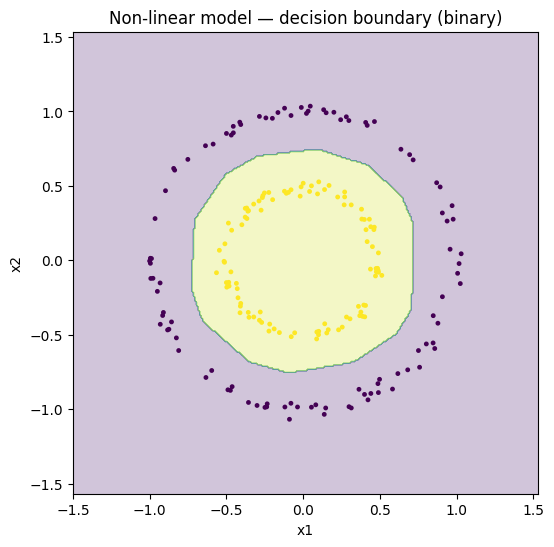

In [ ]:

class NonLinearCircleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model_nl = NonLinearCircleNet().to(device)
optimizer = torch.optim.Adam(model_nl.parameters(), lr=0.01)

def train_binary_nl(model, epochs=800, report_every=100):
    for epoch in range(1, epochs+1):
        model.train()
        logits = model(X_train).squeeze(1)
        loss = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % report_every == 0 or epoch == 1:
            model.eval()
            with torch.inference_mode():
                test_logits = model(X_test).squeeze(1)
                test_loss = loss_fn(test_logits, y_test)
                preds = torch.sigmoid(test_logits) >= 0.5
                acc = metric(preds, y_test.int())
            print(f"Epoch {epoch:4d} | train_loss={loss.item():.4f} | test_loss={test_loss.item():.4f} | test_acc={acc.item()*100:.2f}%")

train_binary_nl(model_nl, epochs=800, report_every=100)
plot_decision_boundary(model_nl, X_test, y_test, title="Non-linear model — decision boundary (binary)")



## 5) Replicating Common Activations (Pure PyTorch Tensors)
Let’s build tiny versions of **ReLU**, **Sigmoid**, and **Tanh** and plot their shapes.


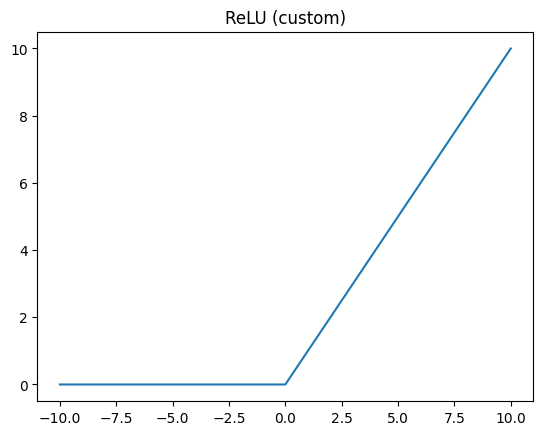

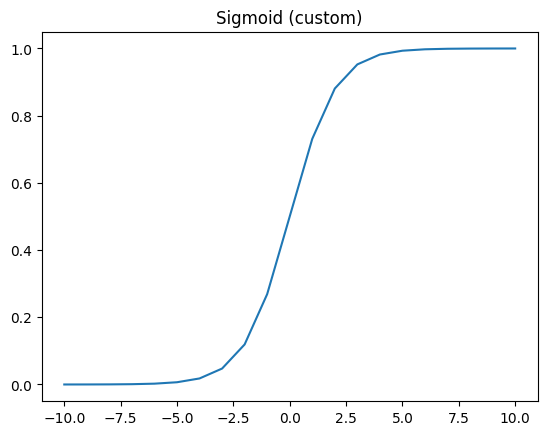

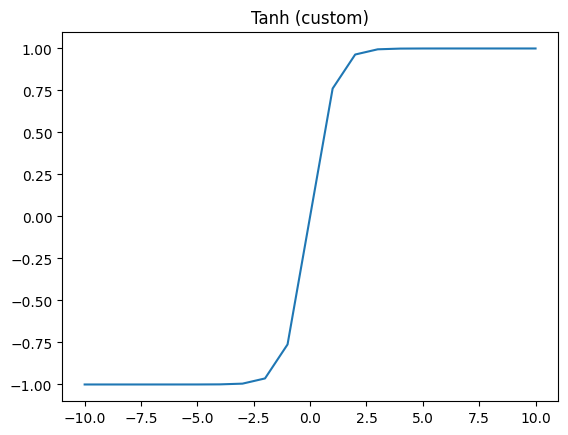

In [ ]:

A = torch.arange(-10, 11, dtype=torch.float32)

def relu_custom(x):
    return torch.maximum(torch.tensor(0.0, dtype=x.dtype, device=x.device), x)

def sigmoid_custom(x):
    return 1.0 / (1.0 + torch.exp(-x))

def tanh_custom(x):
    # tanh(x) = (e^x - e^-x) / (e^x + e^-x)
    ex = torch.exp(x)
    enx = torch.exp(-x)
    return (ex - enx) / (ex + enx)

plt.figure(); plt.plot(A.cpu(), relu_custom(A).cpu()); plt.title("ReLU (custom)"); plt.show()
plt.figure(); plt.plot(A.cpu(), sigmoid_custom(A).cpu()); plt.title("Sigmoid (custom)"); plt.show()
plt.figure(); plt.plot(A.cpu(), tanh_custom(A).cpu()); plt.title("Tanh (custom)"); plt.show()



## 6) Multi-Class Classification (Blobs)
We’ll separate four clusters (classes) using a small MLP and **CrossEntropyLoss**.


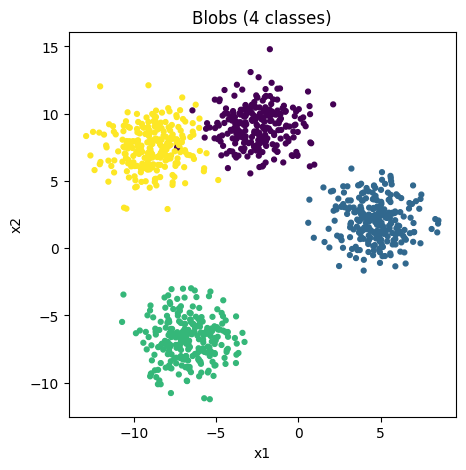

Epoch   1 | train_loss=1.7043 | test_loss=1.4833 | test_acc=25.00%
Epoch  25 | train_loss=0.0578 | test_loss=0.0441 | test_acc=99.50%
Epoch  50 | train_loss=0.0252 | test_loss=0.0166 | test_acc=99.50%
Epoch  75 | train_loss=0.0233 | test_loss=0.0137 | test_acc=99.50%
Epoch 100 | train_loss=0.0223 | test_loss=0.0123 | test_acc=99.50%
Epoch 125 | train_loss=0.0215 | test_loss=0.0111 | test_acc=99.50%
Epoch 150 | train_loss=0.0207 | test_loss=0.0100 | test_acc=99.50%


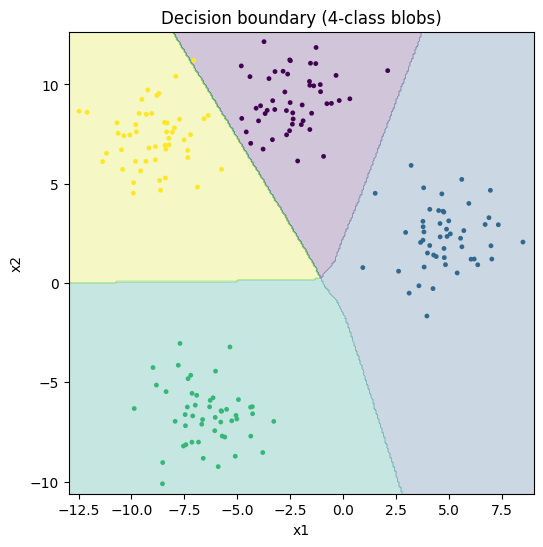

In [ ]:

NUM_CLASSES = 4
Xb, yb = make_blobs(n_samples=1000, centers=NUM_CLASSES, n_features=2, cluster_std=1.5, random_state=seed)
Xb = torch.tensor(Xb, dtype=torch.float32).to(device)
yb = torch.tensor(yb, dtype=torch.long).to(device)

plot_points(Xb.cpu(), yb.cpu(), title="Blobs (4 classes)")

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb.cpu(), yb.cpu(), test_size=0.2, random_state=seed, stratify=yb.cpu())
Xb_tr, Xb_te, yb_tr, yb_te = Xb_tr.to(device), Xb_te.to(device), yb_tr.to(device), yb_te.to(device)

class BlobNet(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, NUM_CLASSES)
        )
    def forward(self, x):
        return self.net(x)

blob_model = BlobNet().to(device)
ce_loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(blob_model.parameters(), lr=0.01)
mc_acc = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)

for epoch in range(1, 151):
    blob_model.train()
    logits = blob_model(Xb_tr)
    loss = ce_loss(logits, yb_tr)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 25 == 0 or epoch == 1:
        blob_model.eval()
        with torch.inference_mode():
            te_logits = blob_model(Xb_te)
            te_loss = ce_loss(te_logits, yb_te)
            preds = torch.argmax(te_logits, dim=1)
            acc = mc_acc(preds, yb_te)
        print(f"Epoch {epoch:3d} | train_loss={loss.item():.4f} | test_loss={te_loss.item():.4f} | test_acc={acc.item()*100:.2f}%")

plot_decision_boundary(blob_model, Xb_te, yb_te, title="Decision boundary (4-class blobs)")



## 7) Exercise: Binary with `make_moons()`
- Create 1,000 samples with `random_state=42`.
- Build a non-linear model that reaches **≥96%** test accuracy.
- Hint: Start small, then widen/deepen or train longer.

*(A compact reference solution is provided below.)*


[Moons] Epoch   1 | train=0.7174 | test=0.6762 | acc=77.00%
[Moons] Epoch 100 | train=0.0633 | test=0.0346 | acc=98.50%
[Moons] Epoch 200 | train=0.0567 | test=0.0345 | acc=98.50%
[Moons] Epoch 300 | train=0.0545 | test=0.0359 | acc=98.50%
[Moons] Epoch 400 | train=0.0535 | test=0.0364 | acc=98.50%
[Moons] Epoch 500 | train=0.0532 | test=0.0366 | acc=98.50%
[Moons] Epoch 600 | train=0.0523 | test=0.0389 | acc=98.50%


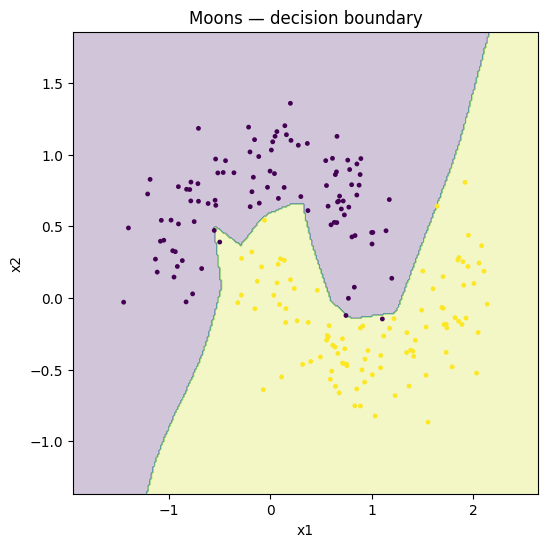

In [ ]:

# Reference solution (feel free to tweak):
Xm, ym = make_moons(n_samples=1000, noise=0.2, random_state=seed)
Xm = torch.tensor(Xm, dtype=torch.float32).to(device)
ym = torch.tensor(ym, dtype=torch.float32).to(device)

Xm_tr, Xm_te, ym_tr, ym_te = train_test_split(Xm.cpu(), ym.cpu(), test_size=0.2, random_state=seed, stratify=ym.cpu())
Xm_tr, Xm_te, ym_tr, ym_te = Xm_tr.to(device), Xm_te.to(device), ym_tr.to(device), ym_te.to(device)

class MoonNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

moon_model = MoonNet().to(device)
moon_opt = torch.optim.Adam(moon_model.parameters(), lr=0.01)
bacc = BinaryAccuracy().to(device)
bce = nn.BCEWithLogitsLoss()

for epoch in range(1, 601):
    moon_model.train()
    logits = moon_model(Xm_tr).squeeze(1)
    loss = bce(logits, ym_tr)
    moon_opt.zero_grad(); loss.backward(); moon_opt.step()

    if epoch % 100 == 0 or epoch == 1:
        moon_model.eval()
        with torch.inference_mode():
            te_logits = moon_model(Xm_te).squeeze(1)
            te_loss = bce(te_logits, ym_te)
            preds = torch.sigmoid(te_logits) >= 0.5
            acc = bacc(preds, ym_te.int())
        print(f"[Moons] Epoch {epoch:3d} | train={loss.item():.4f} | test={te_loss.item():.4f} | acc={acc.item()*100:.2f}%")

plot_decision_boundary(moon_model, Xm_te, ym_te, title="Moons — decision boundary")



## 8) Multi-Class Spirals — A Classic Challenge
The CS231n-style spirals are a fun non-linear, multi-class dataset.


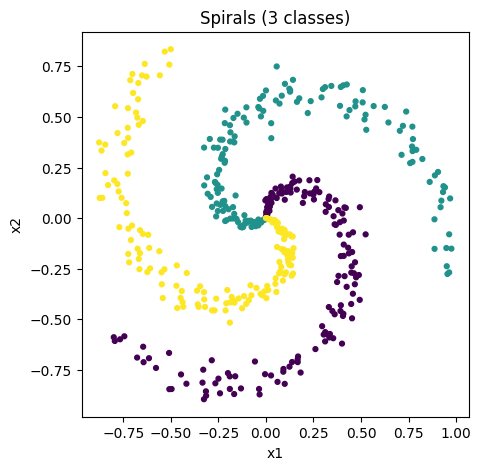

[Spirals] Epoch   1 | train=1.1089 | test=1.0467 | acc=55.56%
[Spirals] Epoch 100 | train=0.0329 | test=0.0270 | acc=100.00%
[Spirals] Epoch 200 | train=0.0184 | test=0.0152 | acc=100.00%
[Spirals] Epoch 300 | train=0.0147 | test=0.0101 | acc=100.00%
[Spirals] Epoch 400 | train=0.0129 | test=0.0108 | acc=100.00%
[Spirals] Epoch 500 | train=0.0117 | test=0.0066 | acc=100.00%
[Spirals] Epoch 600 | train=0.0110 | test=0.0051 | acc=100.00%
[Spirals] Epoch 700 | train=0.0107 | test=0.0043 | acc=100.00%
[Spirals] Epoch 800 | train=0.0103 | test=0.0036 | acc=100.00%


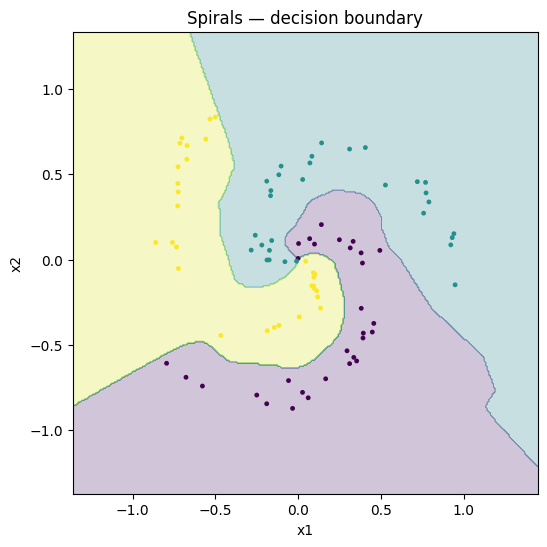

In [ ]:

# Create spirals
N = 150   # per class
K = 3     # classes
D = 2
Xsp = np.zeros((N*K, D), dtype=np.float32)
ysp = np.zeros(N*K, dtype=np.int64)

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    Xsp[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    ysp[ix] = j

Xsp = torch.tensor(Xsp, dtype=torch.float32).to(device)
ysp = torch.tensor(ysp, dtype=torch.long).to(device)

plot_points(Xsp.cpu(), ysp.cpu(), title="Spirals (3 classes)")

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(Xsp.cpu(), ysp.cpu(), test_size=0.2, random_state=seed, stratify=ysp.cpu())
Xs_tr, Xs_te, ys_tr, ys_te = Xs_tr.to(device), Xs_te.to(device), ys_tr.to(device), ys_te.to(device)

class SpiralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, K)
        )
    def forward(self, x): return self.net(x)

spiral = SpiralNet().to(device)
opt = torch.optim.Adam(spiral.parameters(), lr=0.01)
acc3 = MulticlassAccuracy(num_classes=K).to(device)
ce = nn.CrossEntropyLoss()

for epoch in range(1, 801):
    spiral.train()
    logits = spiral(Xs_tr)
    loss = ce(logits, ys_tr)
    opt.zero_grad(); loss.backward(); opt.step()

    if epoch % 100 == 0 or epoch == 1:
        spiral.eval()
        with torch.inference_mode():
            tl = ce(spiral(Xs_te), ys_te)
            preds = torch.argmax(spiral(Xs_te), dim=1)
            a = acc3(preds, ys_te)
        print(f"[Spirals] Epoch {epoch:3d} | train={loss.item():.4f} | test={tl.item():.4f} | acc={a.item()*100:.2f}%")

plot_decision_boundary(spiral, Xs_te, ys_te, title="Spirals — decision boundary")
